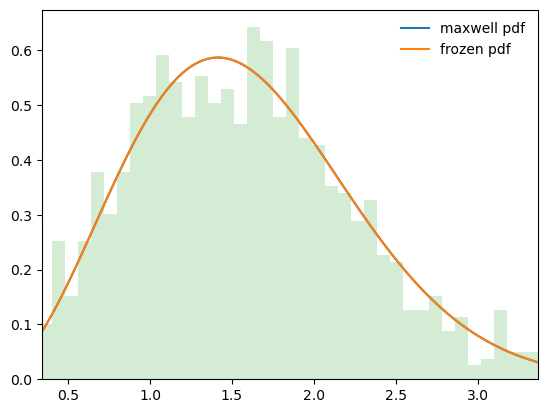

In [8]:
import numpy as np
from scipy.stats import maxwell
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

mean, var, skew, kurt = maxwell.stats(moments='mvsk')

x = np.linspace(maxwell.ppf(0.01),
                maxwell.ppf(0.99), 100)
ax.plot(x, maxwell.pdf(x), label='maxwell pdf')

rv = maxwell()
ax.plot(x, rv.pdf(x), label='frozen pdf')

vals = maxwell.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], maxwell.cdf(vals))

r = maxwell.rvs(size=1000)

ax.hist(r, density=True, bins=50, histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()
    
# def animate(i):
#     t = float(i)*dt
#     line.set_ydata(ww(x, t, k0, a0, vp, vg)) # update y-data
#     timeText.set_text(timeString.format(t))
#     return line, timeText

<IPython.core.display.Javascript object>


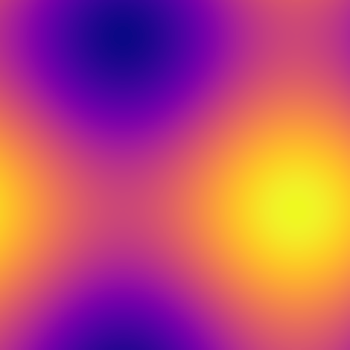

In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim


def f(x, y):
    return np.sin(x) + np.cos(y)


x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 120).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)
ax.axis('off')
ims = []
for i in range(120):
    x += np.pi / 20.
    y += np.pi / 20.
    im = ax.imshow(f(x, y), cmap=plt.get_cmap('plasma'), animated=True)
    ims.append([im])

ani = anim.ArtistAnimation(fig, artists=ims, interval=10, repeat_delay=0)
fig.show()

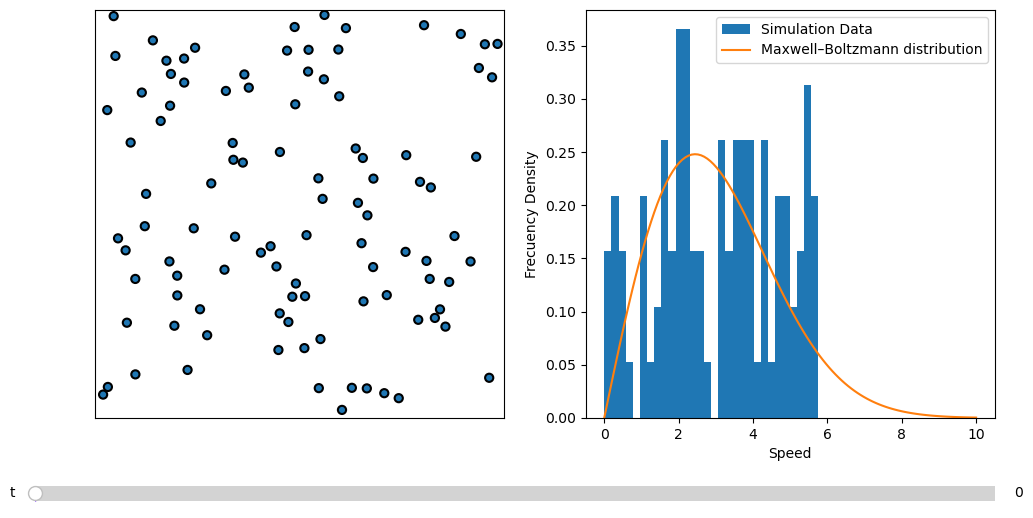

In [11]:
class Particle:
    """Define physics of elastic collision."""
    
    def __init__(self, mass, radius, position, velocity):
        """Initialize a Particle object
        
        mass the mass of particle
        radius the radius of particle
        position the position vector of particle
        velocity the velocity vector of particle
        """
        self.mass = mass
        self.radius = radius
        
        # last position and velocity
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        
        # all position and velocities recorded during the simulation
        self.solpos = [np.copy(self.position)]
        self.solvel = [np.copy(self.velocity)]
        self.solvel_mag = [np.linalg.norm(np.copy(self.velocity))]
        
    def compute_step(self, step):
        """Compute position of next step."""
        self.position += step * self.velocity
        self.solpos.append(np.copy(self.position)) 
        self.solvel.append(np.copy(self.velocity)) 
        self.solvel_mag.append(np.linalg.norm(np.copy(self.velocity)))     
    
    def check_coll(self, particle):
        """Check if there is a collision with another particle."""
        
        r1, r2 = self.radius, particle.radius
        x1, x2 = self.position, particle.position
        di = x2-x1
        norm = np.linalg.norm(di)
        if norm-(r1+r2)*1.1 < 0:
            return True
        else:
            return False

    def compute_coll(self, particle, step):
        """Compute velocity after collision with another particle."""
        m1, m2 = self.mass, particle.mass
        r1, r2 = self.radius, particle.radius
        v1, v2 = self.velocity, particle.velocity
        x1, x2 = self.position, particle.position
        di = x2-x1
        norm = np.linalg.norm(di)
        if norm-(r1+r2)*1.1 < step*abs(np.dot(v1-v2, di))/norm:
            self.velocity = v1 - 2. * m2/(m1+m2) * np.dot(v1-v2, di) / (np.linalg.norm(di)**2.) * di
            particle.velocity = v2 - 2. * m1/(m2+m1) * np.dot(v2-v1, (-di)) / (np.linalg.norm(di)**2.) * (-di)

    def compute_refl(self, step, size):
        """Compute velocity after hitting an edge.
        step the computation step
        size the medium size
        """
        r, v, x = self.radius, self.velocity, self.position
        projx = step*abs(np.dot(v,np.array([1.,0.])))
        projy = step*abs(np.dot(v,np.array([0.,1.])))
        if abs(x[0])-r < projx or abs(size-x[0])-r < projx:
            self.velocity[0] *= -1
        if abs(x[1])-r < projy or abs(size-x[1])-r < projy:
            self.velocity[1] *= -1.

def solve_step(particle_list, step, size):
    """Solve a step for every particle."""
    
    # Detect edge-hitting and collision of every particle
    for i in range(len(particle_list)):
        particle_list[i].compute_refl(step,size)
        for j in range(i+1,len(particle_list)):
                particle_list[i].compute_coll(particle_list[j],step)    

    # Compute position of every particle  
    for particle in particle_list:
        particle.compute_step(step)

################################################################################################################################

def init_list_random(N, radius, mass, boxsize):
    """Generate N Particle objects in a random way in a list."""
    particle_list = []

    for i in range(N):
        
        v_mag = np.random.rand(1)*6
        v_ang = np.random.rand(1)*2*np.pi
        v = np.append(v_mag*np.cos(v_ang), v_mag*np.sin(v_ang))
        
        collision = True
        while(collision == True):
            
            collision = False
            pos = radius + np.random.rand(2)*(boxsize-2*radius) 
            newparticle = Particle(mass, radius, pos, v)
            for j in range(len(particle_list)):

                collision = newparticle.check_coll( particle_list[j] )

                if collision == True:
                    break

        particle_list.append(newparticle)
    return particle_list

particle_number = 100
boxsize = 200.

# You need a larger tfin and stepnumber to get the equilibrium state. But the computation takes more time.
tfin = 10
stepnumber = 150

timestep = tfin/stepnumber

particle_list = init_list_random(particle_number, radius = 2, mass = 1, boxsize = 200)

# Compute simulation (It takes some time if stepnumber and particle_number are large)
for i in range(stepnumber):
    solve_step(particle_list, timestep, boxsize)
    #print(i)

################################################################################################################################
# Visualization of the solution with matplotlib. It use a slider to change the time

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,2,1)

hist = fig.add_subplot(1,2,2)

plt.subplots_adjust(bottom=0.2,left=0.15)

ax.axis('equal')
ax.axis([-1, 30, -1, 30])

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim([0,boxsize])
ax.set_ylim([0,boxsize])

# Draw Particles as circles
circle = [None]*particle_number
for i in range(particle_number):
    circle[i] = plt.Circle((particle_list[i].solpos[0][0], particle_list[i].solpos[0][1]), particle_list[i].radius, ec="black", lw=1.5, zorder=20)
    ax.add_patch(circle[i])

# Graph Particles speed histogram
vel_mod = [particle_list[i].solvel_mag[0] for i in range(len(particle_list))]
hist.hist(vel_mod, bins= 30, density = True, label = "Simulation Data")
hist.set_xlabel("Speed")
hist.set_ylabel("Frecuency Density")



# Compute 2d Boltzmann distribution

#total energy should be constant for any time index
def total_Energy(particle_list, index): 
    return sum([particle_list[i].mass / 2. * particle_list[i].solvel_mag[index]**2  for i in range(len(particle_list))])


E = total_Energy(particle_list, 0)
Average_E = E/len(particle_list) 
k = 1.38064852e-23
T = 2*Average_E/(2*k)
m = particle_list[0].mass
v = np.linspace(0,10,120)
fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
hist.plot(v,fv, label = "Maxwell–Boltzmann distribution") 
hist.legend(loc ="upper right")


from matplotlib.widgets import Slider

slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])
slider = Slider(slider_ax,      # the axes object containing the slider
                  't',            # the name of the slider parameter
                  0,          # minimal value of the parameter
                  tfin,          # maximal value of the parameter
                  valinit=0,  # initial value of the parameter 
                  color = '#5c05ff' 
                 )

def update(time):
    i = int(np.rint(time/timestep))
    
    #ax.set_title('Energy =' + str(Energy[i]))
    
    # Draw Particles as circles
    for j in range(particle_number):
        circle[j].center = particle_list[j].solpos[i][0], particle_list[j].solpos[i][1]
    hist.clear()    
    
    # Graph Particles speed histogram
    vel_mod = [particle_list[j].solvel_mag[i] for j in range(len(particle_list))]
    hist.hist(vel_mod, bins= 30, density = True, label = "Simulation Data")
    hist.set_xlabel("Speed")
    hist.set_ylabel("Frecuency Density")
    
    # Compute 2d Boltzmann distribution
    E = total_Energy(particle_list, i)
    Average_E = E/len(particle_list) 
    k = 1.38064852e-23
    T = 2*Average_E/(2*k)
    m = particle_list[0].mass
    v = np.linspace(0,10,120)
    fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
    hist.plot(v,fv, label = "Maxwell–Boltzmann distribution") 
    hist.legend(loc ="upper right")
    
slider.on_changed(update)
plt.show()

<IPython.core.display.Javascript object>


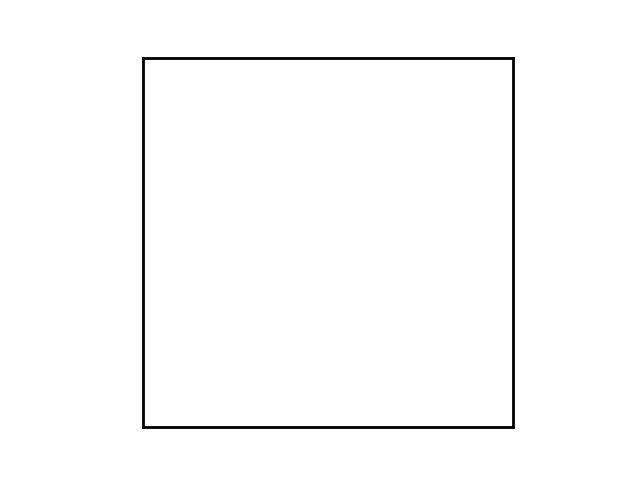

C:\Users\jingt_41vra31\miniconda3\lib\site-packages\matplotlib\animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation
from itertools import combinations

class Particle:
    """A class representing a two-dimensional particle."""

    def __init__(self, x, y, vx, vy, radius=0.01, styles=None):
        """Initialize the particle's position, velocity, and radius.

        Any key-value pairs passed in the styles dictionary will be passed
        as arguments to Matplotlib's Circle patch constructor.

        """

        self.r = np.array((x, y))
        self.v = np.array((vx, vy))
        self.radius = radius

        self.styles = styles
        if not self.styles:
            # Default circle styles
            self.styles = {'edgecolor': 'b', 'fill': False}

    # For convenience, map the components of the particle's position and
    # velocity vector onto the attributes x, y, vx and vy.
    @property
    def x(self):
        return self.r[0]
    @x.setter
    def x(self, value):
        self.r[0] = value
    @property
    def y(self):
        return self.r[1]
    @y.setter
    def y(self, value):
        self.r[1] = value
    @property
    def vx(self):
        return self.v[0]
    @vx.setter
    def vx(self, value):
        self.v[0] = value
    @property
    def vy(self):
        return self.v[1]
    @vy.setter
    def vy(self, value):
        self.v[1] = value

    def overlaps(self, other):
        """Does the circle of this Particle overlap that of other?"""

        return np.hypot(*(self.r - other.r)) < self.radius + other.radius

    def draw(self, ax):
        """Add this Particle's Circle patch to the Matplotlib Axes ax."""

        circle = Circle(xy=self.r, radius=self.radius, **self.styles)
        ax.add_patch(circle)
        return circle

    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""

        self.r += self.v * dt

        # Make the Particles bounce off the walls
        if self.x - self.radius < 0:
            self.x = self.radius
            self.vx = -self.vx
        if self.x + self.radius > 1:
            self.x = 1-self.radius
            self.vx = -self.vx
        if self.y - self.radius < 0:
            self.y = self.radius
            self.vy = -self.vy
        if self.y + self.radius > 1:
            self.y = 1-self.radius
            self.vy = -self.vy

class Simulation:
    """A class for a simple hard-circle molecular dynamics simulation.

    The simulation is carried out on a square domain: 0 <= x < 1, 0 <= y < 1.

    """

    def __init__(self, n, radius=0.01, styles=None):
        """Initialize the simulation with n Particles with radii radius.

        radius can be a single value or a sequence with n values.

        Any key-value pairs passed in the styles dictionary will be passed
        as arguments to Matplotlib's Circle patch constructor when drawing
        the Particles.

        """

        self.init_particles(n, radius, styles)

    def init_particles(self, n, radius, styles=None):
        """Initialize the n Particles of the simulation.

        Positions and velocities are chosen randomly; radius can be a single
        value or a sequence with n values.

        """

        try:
            iterator = iter(radius)
            assert n == len(radius)
        except TypeError:
            # r isn't iterable: turn it into a generator that returns the
            # same value n times.
            def r_gen(n, radius):
                for i in range(n):
                    yield radius
            radius = r_gen(n, radius)

        self.n = n
        self.particles = []
        for i, rad in enumerate(radius):
            # Try to find a random initial position for this particle.
            while True:
                # Choose x, y so that the Particle is entirely inside the
                # domain of the simulation.
                x, y = rad + (1 - 2*rad) * np.random.random(2)
                # Choose a random velocity (within some reasonable range of
                # values) for the Particle.
                vr = 0.1 * np.random.random() + 0.05
                vphi = 2*np.pi * np.random.random()
                vx, vy = vr * np.cos(vphi), vr * np.sin(vphi)
                particle = Particle(x, y, vx, vy, rad, styles)
                # Check that the Particle doesn't overlap one that's already
                # been placed.
                for p2 in self.particles:
                    if p2.overlaps(particle):
                        break
                else:
                    self.particles.append(particle)
                    break

    def handle_collisions(self):
        """Detect and handle any collisions between the Particles.

        When two Particles collide, they do so elastically: their velocities
        change such that both energy and momentum are conserved.

        """

        def change_velocities(p1, p2):
            """
            Particles p1 and p2 have collided elastically: update their
            velocities.

            """

            m1, m2 = p1.radius**2, p2.radius**2
            M = m1 + m2
            r1, r2 = p1.r, p2.r
            d = np.linalg.norm(r1 - r2)**2
            v1, v2 = p1.v, p2.v
            u1 = v1 - 2*m2 / M * np.dot(v1-v2, r1-r2) / d * (r1 - r2)
            u2 = v2 - 2*m1 / M * np.dot(v2-v1, r2-r1) / d * (r2 - r1)
            p1.v = u1
            p2.v = u2

        # We're going to need a sequence of all of the pairs of particles when
        # we are detecting collisions. combinations generates pairs of indexes
        # into the self.particles list of Particles on the fly.
        pairs = combinations(range(self.n), 2)
        for i,j in pairs:
            if self.particles[i].overlaps(self.particles[j]):
                change_velocities(self.particles[i], self.particles[j])

    def advance_animation(self, dt):
        """Advance the animation by dt, returning the updated Circles list."""

        for i, p in enumerate(self.particles):
            p.advance(dt)
            self.circles[i].center = p.r
        self.handle_collisions()
        return self.circles

    def advance(self, dt):
        """Advance the animation by dt."""
        for i, p in enumerate(self.particles):
            p.advance(dt)
        self.handle_collisions()

    def init(self):
        """Initialize the Matplotlib animation."""

        self.circles = []
        for particle in self.particles:
            self.circles.append(particle.draw(self.ax))
        return self.circles

    def animate(self, i):
        """The function passed to Matplotlib's FuncAnimation routine."""

        self.advance_animation(0.01)
        return self.circles

    def do_animation(self, save=False):
        """Set up and carry out the animation of the molecular dynamics.

        To save the animation as a MP4 movie, set save=True.
        """

        fig, self.ax = plt.subplots()
        for s in ['top','bottom','left','right']:
            self.ax.spines[s].set_linewidth(2)
        self.ax.set_aspect('equal', 'box')
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 1)
        self.ax.xaxis.set_ticks([])
        self.ax.yaxis.set_ticks([])
        anim = animation.FuncAnimation(fig, self.animate, init_func=self.init,
                               frames=800, interval=2, blit=True)
        if save:
            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=100, bitrate=1800)
            anim.save('collision.mp4', writer=writer)
        else:
            plt.show()


if __name__ == '__main__':
    nparticles = 50
    radii = np.random.random(nparticles)*0.03+0.02
    styles = {'edgecolor': 'C0', 'linewidth': 2, 'fill': None}
    sim = Simulation(nparticles, radii, styles)
    sim.do_animation(save=False)

<IPython.core.display.Javascript object>


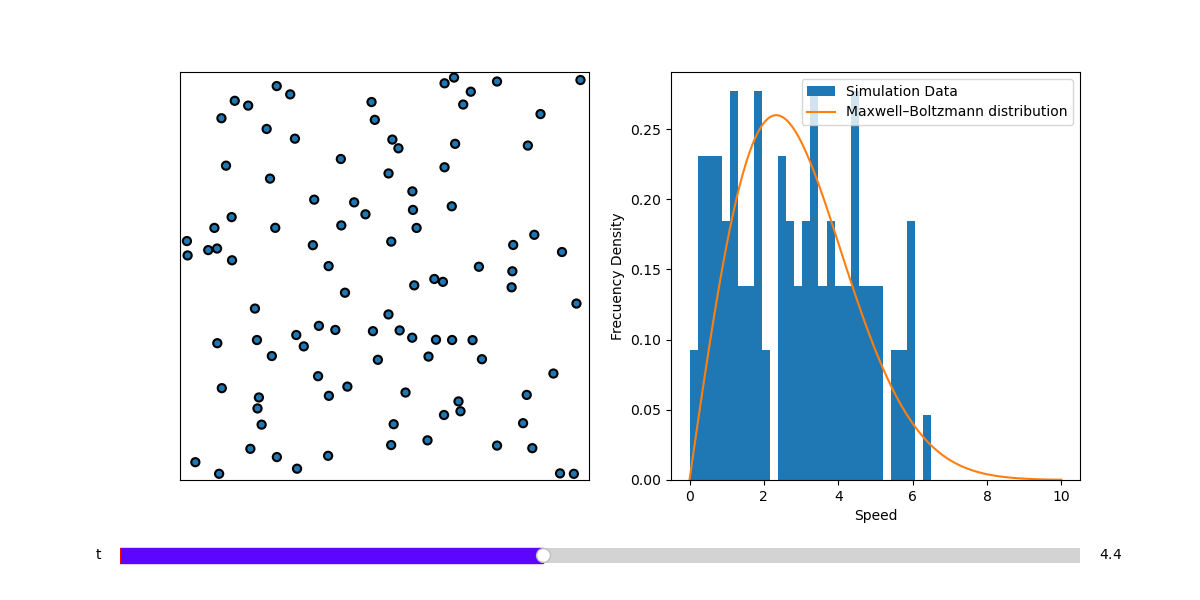

In [5]:
import numpy as np




class Particle:
    """Define physics of elastic collision."""
    
    def __init__(self, mass, radius, position, velocity):
        """Initialize a Particle object
        
        mass the mass of particle
        radius the radius of particle
        position the position vector of particle
        velocity the velocity vector of particle
        """
        self.mass = mass
        self.radius = radius
        
        # last position and velocity
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        
        # all position and velocities recorded during the simulation
        self.solpos = [np.copy(self.position)]
        self.solvel = [np.copy(self.velocity)]
        self.solvel_mag = [np.linalg.norm(np.copy(self.velocity))]
        
    def compute_step(self, step):
        """Compute position of next step."""
        self.position += step * self.velocity
        self.solpos.append(np.copy(self.position)) 
        self.solvel.append(np.copy(self.velocity)) 
        self.solvel_mag.append(np.linalg.norm(np.copy(self.velocity))) 
        

    
    
    def check_coll(self, particle):
        """Check if there is a collision with another particle."""
        
        r1, r2 = self.radius, particle.radius
        x1, x2 = self.position, particle.position
        di = x2-x1
        norm = np.linalg.norm(di)
        if norm-(r1+r2)*1.1 < 0:
            return True
        else:
            return False

    
    def compute_coll(self, particle, step):
        """Compute velocity after collision with another particle."""
        m1, m2 = self.mass, particle.mass
        r1, r2 = self.radius, particle.radius
        v1, v2 = self.velocity, particle.velocity
        x1, x2 = self.position, particle.position
        di = x2-x1
        norm = np.linalg.norm(di)
        if norm-(r1+r2)*1.1 < step*abs(np.dot(v1-v2, di))/norm:
            self.velocity = v1 - 2. * m2/(m1+m2) * np.dot(v1-v2, di) / (np.linalg.norm(di)**2.) * di
            particle.velocity = v2 - 2. * m1/(m2+m1) * np.dot(v2-v1, (-di)) / (np.linalg.norm(di)**2.) * (-di)
            

    def compute_refl(self, step, size):
        """Compute velocity after hitting an edge.
        step the computation step
        size the medium size
        """
        r, v, x = self.radius, self.velocity, self.position
        projx = step*abs(np.dot(v,np.array([1.,0.])))
        projy = step*abs(np.dot(v,np.array([0.,1.])))
        if abs(x[0])-r < projx or abs(size-x[0])-r < projx:
            self.velocity[0] *= -1
        if abs(x[1])-r < projy or abs(size-x[1])-r < projy:
            self.velocity[1] *= -1.


def solve_step(particle_list, step, size):
    """Solve a step for every particle."""
    
    # Detect edge-hitting and collision of every particle
    for i in range(len(particle_list)):
        particle_list[i].compute_refl(step,size)
        for j in range(i+1,len(particle_list)):
                particle_list[i].compute_coll(particle_list[j],step)    

                
    # Compute position of every particle  
    for particle in particle_list:
        particle.compute_step(step)




################################################################################################################################





def init_list_random(N, radius, mass, boxsize):
    """Generate N Particle objects in a random way in a list."""
    particle_list = []

    for i in range(N):
        
        v_mag = np.random.rand(1)*6
        v_ang = np.random.rand(1)*2*np.pi
        v = np.append(v_mag*np.cos(v_ang), v_mag*np.sin(v_ang))
        
        collision = True
        while(collision == True):
            
            collision = False
            pos = radius + np.random.rand(2)*(boxsize-2*radius) 
            newparticle = Particle(mass, radius, pos, v)
            for j in range(len(particle_list)):

                collision = newparticle.check_coll( particle_list[j] )

                if collision == True:
                    break

        particle_list.append(newparticle)
    return particle_list



particle_number = 100
boxsize = 200.

# You need a larger tfin and stepnumber to get the equilibrium state. But the computation takes more time.
tfin = 10
stepnumber = 150

timestep = tfin/stepnumber

particle_list = init_list_random(particle_number, radius = 2, mass = 1, boxsize = 200)

# Compute simulation (It takes some time if stepnumber and particle_number are large)
for i in range(stepnumber):
    solve_step(particle_list, timestep, boxsize)
    #print(i)






################################################################################################################################


# Visualization of the solution with matplotlib. It use a slider to change the time


import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,2,1)

hist = fig.add_subplot(1,2,2)

plt.subplots_adjust(bottom=0.2,left=0.15)

ax.axis('equal')
ax.axis([-1, 30, -1, 30])

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim([0,boxsize])
ax.set_ylim([0,boxsize])

# Draw Particles as circles
circle = [None]*particle_number
for i in range(particle_number):
    circle[i] = plt.Circle((particle_list[i].solpos[0][0], particle_list[i].solpos[0][1]), particle_list[i].radius, ec="black", lw=1.5, zorder=20)
    ax.add_patch(circle[i])

# Graph Particles speed histogram
vel_mod = [particle_list[i].solvel_mag[0] for i in range(len(particle_list))]
hist.hist(vel_mod, bins= 30, density = True, label = "Simulation Data")
hist.set_xlabel("Speed")
hist.set_ylabel("Frecuency Density")



# Compute 2d Boltzmann distribution

#total energy should be constant for any time index
def total_Energy(particle_list, index): 
    return sum([particle_list[i].mass / 2. * particle_list[i].solvel_mag[index]**2  for i in range(len(particle_list))])


E = total_Energy(particle_list, 0)
Average_E = E/len(particle_list) 
k = 1.38064852e-23
T = 2*Average_E/(2*k)
m = particle_list[0].mass
v = np.linspace(0,10,120)
fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
hist.plot(v,fv, label = "Maxwell–Boltzmann distribution") 
hist.legend(loc ="upper right")


from matplotlib.widgets import Slider

slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])
slider = Slider(slider_ax,      # the axes object containing the slider
                  't',            # the name of the slider parameter
                  0,          # minimal value of the parameter
                  tfin,          # maximal value of the parameter
                  valinit=0,  # initial value of the parameter 
                  color = '#5c05ff' 
                 )

def update(time):
    i = int(np.rint(time/timestep))
    
    #ax.set_title('Energy =' + str(Energy[i]))
    
    # Draw Particles as circles
    for j in range(particle_number):
        circle[j].center = particle_list[j].solpos[i][0], particle_list[j].solpos[i][1]
    hist.clear()    
    
    # Graph Particles speed histogram
    vel_mod = [particle_list[j].solvel_mag[i] for j in range(len(particle_list))]
    hist.hist(vel_mod, bins= 30, density = True, label = "Simulation Data")
    hist.set_xlabel("Speed")
    hist.set_ylabel("Frecuency Density")
    
    # Compute 2d Boltzmann distribution
    E = total_Energy(particle_list, i)
    Average_E = E/len(particle_list) 
    k = 1.38064852e-23
    T = 2*Average_E/(2*k)
    m = particle_list[0].mass
    v = np.linspace(0,10,120)
    fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
    hist.plot(v,fv, label = "Maxwell–Boltzmann distribution") 
    hist.legend(loc ="upper right")
    
slider.on_changed(update)
plt.show()

In [ ]:
pseudocode

simulate collision
y = collision count
x = speed